In [2]:
# Header:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from decimal import Decimal
from scipy.stats import chi2
from scipy.integrate import quad

def format_e(n):
    a = '%e' % Decimal(n)
    return a.split('e')[0].rstrip('0').rstrip('.')+'e'+a.split('e')[1]

In [3]:
def beugung_spalt(x):
    return np.sinc(x)**2

def beugung_doppelspalt(x, v):
    return np.sinc(x)**2*np.cos(np.pi*v*x)**2

def spalt(k):
    return d/np.pi*np.sin(k*d/2)/(k*d/2)*np.cos(y*k)

def doppelspalt(k):
    return d/np.pi*np.cos(k*g/2)*np.sin(k*d/2)/(k*d/2)*np.cos(y*k)

Abzissenskalierung: 
a [1/px]= 1.337324e-02  +-  7.494438e-06
Hintergrundrauschen: 
h [counts]= 6.070585e+01  +-  1.091835e-01
Chi-Quadrat = 32832.64250418372
Freiheitsgrade = 3895
Chi-Quadrat reduziert = 8.429433248827657
Wahrscheinlichkeit ein größeres oder gleiches Chi-Quadrat zu erhalten = 0.0 %


Intensitätsskalierung: 
k = 9.740385e-02


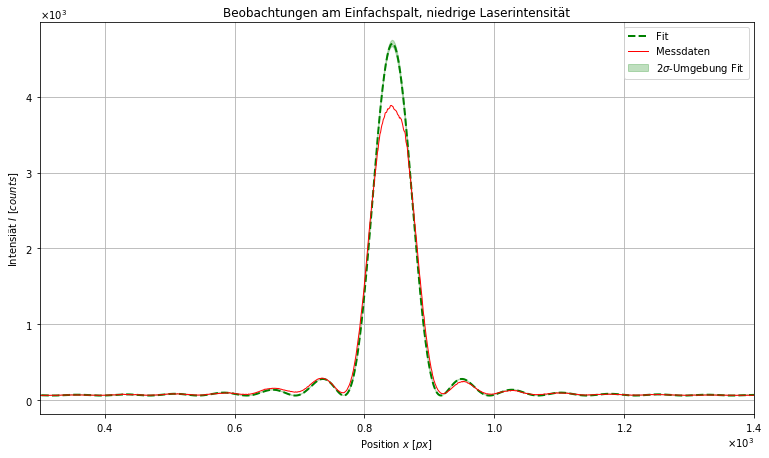

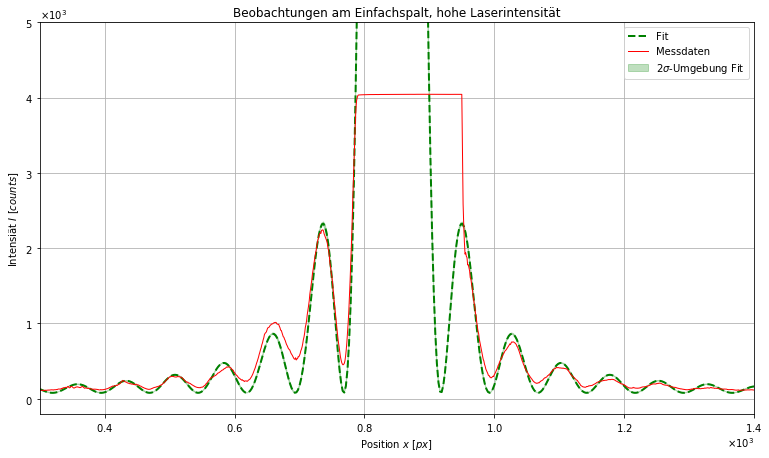

In [111]:
x1_ext = np.array([90,512,547,588,615,662,694,735,767,993,1027,1063,1099,1141,1182,2032])
Fehler_x1_ext = np.full(x1_ext.size, 5)
I1_ext = np.array([60,85,66,99,73,156,104,289,97,77,130,71,94,66,79,58])
Fehler_I1_ext = np.full(I1_ext.size, 2)

x2_ext = np.array([20,502,547,588,615,664,695,736,767,995,1027,1065,1103,1139,1179,2039])
Fehler_x2_ext = np.full(x2_ext.size, 5)
I2_ext = np.array([59,298,145,430,228,1007,515,2246,451,227,758,205,405,153,256,63])
Fehler_I2_ext = np.full(I2_ext.size, 2)

x1, I1 = np.loadtxt('data/233.1.1.ccd',skiprows=14,usecols=(0, 1), unpack=True)
x2, I2 = np.loadtxt('data/233.1.2.ccd',skiprows=14,usecols=(0, 1), unpack=True)

hintergrund1 = (I1_ext[0]+I1_ext[I1_ext.size-1])/2
hintergrund2 = (I2_ext[0]+I2_ext[I2_ext.size-1])/2

scale = np.mean((I1_ext[1:I1_ext.size-1]-hintergrund1)/(I2_ext[1:I2_ext.size-1]-hintergrund2))
I2_scaled = (I2-hintergrund2)*scale+hintergrund1

x_both = np.array([*x1, *x2[0:778], *x2[975:2048]])
I_both = np.array([*I1, *I2_scaled[0:778], *I2_scaled[975:2048]])
x_both, I_both = (list(t) for t in zip(*sorted(zip(x_both, I_both))))


Fehler_x_both = np.full(len(x_both), 1)
Fehler_I_both = np.full(len(I_both), 2)
#Fitfunktion
from scipy import odr

def fit_func(p, x):
    (h, A, mu, a) = p # c: Konstante
    return A*beugung_spalt(a*(x-mu))+h

model = odr.Model(fit_func)

#darzustellende Daten
x = x_both
y = I_both
delta_x = Fehler_x_both
delta_y = Fehler_I_both

#Startparameter
try:
    popt_iterate
except NameError:
    para0 = [60, 3000, 845, 0.013]
else: 
    para0 = popt_iterate

data = odr.RealData(x, y, sx=delta_x, sy=delta_y)
odr = odr.ODR(data, model, beta0=para0 )
out = odr.run()

#1-Sigma
popt = out.beta
perr = out.sd_beta

#Sigma-Umgebung
nstd = 2 # um n-Sigma-Umgebung im Diagramm zu zeichnen

popt_top = popt+nstd*perr
popt_bot = popt-nstd*perr

#Plot-Umgebung
x_fit = np.linspace(min(x)-(max(x)-min(x))/10, max(x)+(max(x)-min(x))/10, 1000)
fit = fit_func(popt, x_fit)
fit_top = fit_func(popt_top, x_fit)
fit_bot = fit_func(popt_bot, x_fit)

fit2 = (fit_func(popt, x_fit)-hintergrund1)/scale+hintergrund2
fit2_top = (fit_func(popt_top, x_fit)-hintergrund1)/scale+hintergrund2
fit2_bot = (fit_func(popt_bot, x_fit)-hintergrund1)/scale+hintergrund2

chisquare = out.sum_square
dof=len(x)-popt.size #dof:degrees of freedom, Freiheitsgrad
chisquare_red = chisquare/dof
prob = round(1-chi2.cdf(chisquare,dof),2)*100

fig, ax = plt.subplots(1, figsize=[6.4 *2, 4.8 *1.5])
plt.ticklabel_format(axis='both', style='sci', scilimits=(0,3), useMathText=True)
plt.title('Beobachtungen am Einfachspalt, niedrige Laserintensität')
plt.grid(True)
plt.xlim(300, 1400)
plt.plot(x_fit, fit, 'g--', lw=2, label='Fit')
ax.fill_between(x_fit, fit_top, fit_bot, color='g', alpha=.25, label=str(nstd)+'$\sigma$-Umgebung Fit')
plt.xlabel('Position '+r'${x}$'+' '+r'${[px]}$')
plt.ylabel('Intensiät '+r'${I}$'+' '+r'${[counts]}$')
plt.plot(x1, I1, 'r', lw=1, label='Messdaten')
plt.legend(loc='best')
plt.savefig('figures/233_Fig1prov.pdf', format='pdf', bbox_inches='tight')

fig, ax = plt.subplots(1, figsize=[6.4 *2, 4.8 *1.5])
plt.ticklabel_format(axis='both', style='sci', scilimits=(0,3), useMathText=True)
plt.title('Beobachtungen am Einfachspalt, hohe Laserintensität')
plt.grid(True)
plt.xlim(300, 1400)
plt.ylim(-200,5000)
plt.plot(x_fit, fit2, 'g--', lw=2, label='Fit')
ax.fill_between(x_fit, fit2_top, fit2_bot, color='g', alpha=.25, label=str(nstd)+'$\sigma$-Umgebung Fit')
plt.xlabel('Position '+r'${x}$'+' '+r'${[px]}$')
plt.ylabel('Intensiät '+r'${I}$'+' '+r'${[counts]}$')
plt.plot(x2, I2, 'r', lw=1, label='Messdaten')
plt.legend(loc='best')
plt.savefig('figures/233_Fig2prov.pdf', format='pdf', bbox_inches='tight')

#Auswertung
a = popt[3]
Fehler_a = perr[3]

h = popt[0]
Fehler_h = perr[0]

#Ausgabe
print('Abzissenskalierung: ')
print('a [1/px]=', format_e(a), ' +- ', format_e(Fehler_a))
print('Hintergrundrauschen: ')
print('h [counts]=', format_e(h), ' +- ', format_e(Fehler_h))
print('Chi-Quadrat =', chisquare)
print('Freiheitsgrade =', dof)
print('Chi-Quadrat reduziert =', chisquare_red)
print('Wahrscheinlichkeit ein größeres oder gleiches Chi-Quadrat zu erhalten =', prob, '%')
print('\n')                    
print('Intensitätsskalierung: ')
print('k =',  format_e(scale))

popt_iterate = popt

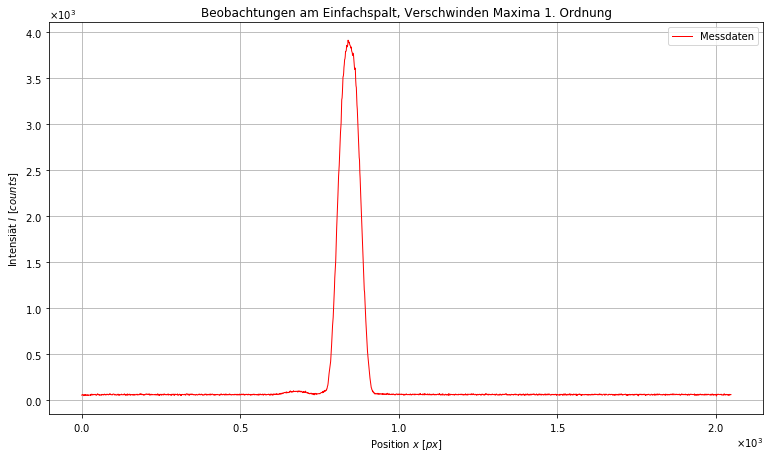

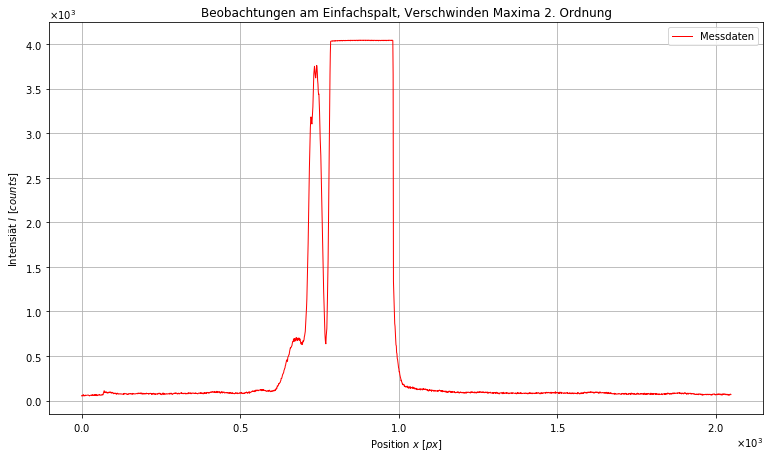

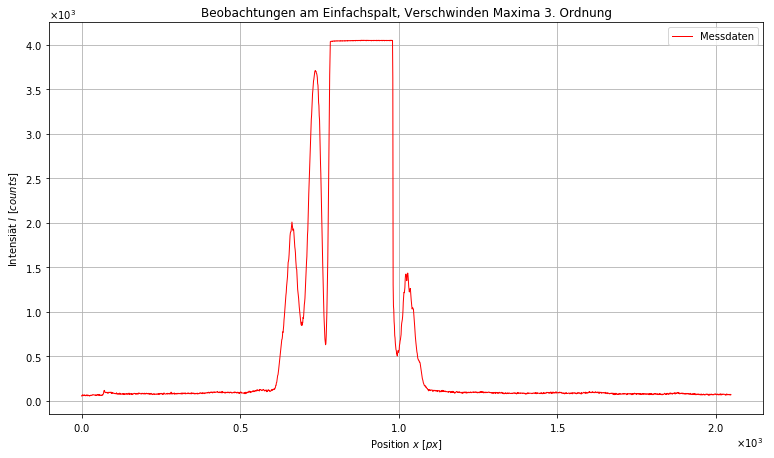

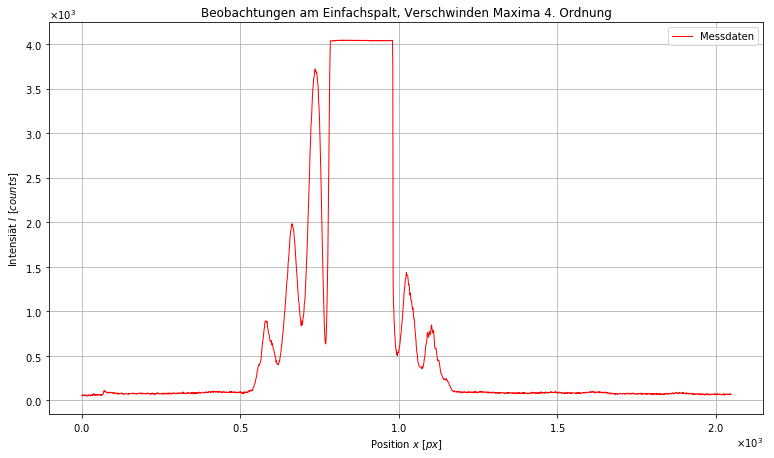

In [72]:
x, I = np.loadtxt('data/233.1.3.ccd',skiprows=14,usecols=(0, 1), unpack=True)
fig, ax = plt.subplots(1, figsize=[6.4 *2, 4.8 *1.5])
plt.ticklabel_format(axis='both', style='sci', scilimits=(0,3), useMathText=True)
plt.title('Beobachtungen am Einfachspalt, Verschwinden Maxima 1. Ordnung')
plt.grid(True)
plt.xlabel('Position '+r'${x}$'+' '+r'${[px]}$')
plt.ylabel('Intensiät '+r'${I}$'+' '+r'${[counts]}$')
plt.plot(x, I, 'r', lw=1, label='Messdaten')
plt.legend(loc='best')
plt.savefig('figures/233_Fig3.pdf', format='pdf', bbox_inches='tight')

x, I = np.loadtxt('data/233.1.4.ccd',skiprows=14,usecols=(0, 1), unpack=True)
fig, ax = plt.subplots(1, figsize=[6.4 *2, 4.8 *1.5])
plt.ticklabel_format(axis='both', style='sci', scilimits=(0,3), useMathText=True)
plt.title('Beobachtungen am Einfachspalt, Verschwinden Maxima 2. Ordnung')
plt.grid(True)
plt.xlabel('Position '+r'${x}$'+' '+r'${[px]}$')
plt.ylabel('Intensiät '+r'${I}$'+' '+r'${[counts]}$')
plt.plot(x, I, 'r', lw=1, label='Messdaten')
plt.legend(loc='best')
plt.savefig('figures/233_Fig4.pdf', format='pdf', bbox_inches='tight')

x, I = np.loadtxt('data/233.1.5.ccd',skiprows=14,usecols=(0, 1), unpack=True)
fig, ax = plt.subplots(1, figsize=[6.4 *2, 4.8 *1.5])
plt.ticklabel_format(axis='both', style='sci', scilimits=(0,3), useMathText=True)
plt.title('Beobachtungen am Einfachspalt, Verschwinden Maxima 3. Ordnung')
plt.grid(True)
plt.xlabel('Position '+r'${x}$'+' '+r'${[px]}$')
plt.ylabel('Intensiät '+r'${I}$'+' '+r'${[counts]}$')
plt.plot(x, I, 'r', lw=1, label='Messdaten')
plt.legend(loc='best')
plt.savefig('figures/233_Fig5.pdf', format='pdf', bbox_inches='tight')

x, I = np.loadtxt('data/233.1.6.ccd',skiprows=14,usecols=(0, 1), unpack=True)
fig, ax = plt.subplots(1, figsize=[6.4 *2, 4.8 *1.5])
plt.ticklabel_format(axis='both', style='sci', scilimits=(0,3), useMathText=True)
plt.title('Beobachtungen am Einfachspalt, Verschwinden Maxima 4. Ordnung')
plt.grid(True)
plt.xlabel('Position '+r'${x}$'+' '+r'${[px]}$')
plt.ylabel('Intensiät '+r'${I}$'+' '+r'${[counts]}$')
plt.plot(x, I, 'r', lw=1, label='Messdaten')
plt.legend(loc='best')
plt.savefig('figures/233_Fig6.pdf', format='pdf', bbox_inches='tight')

Abstand pro Ordnungszahl in der Bildebene:
S_1 [px / 1] = 7.428511e+01  +-  3.380067e-02
Chi-Quadrat = 17.448390867580066
Freiheitsgrade = 33
Chi-Quadrat reduziert = 0.5287391171993959
Wahrscheinlichkeit ein größeres oder gleiches Chi-Quadrat zu erhalten = 99.0 %


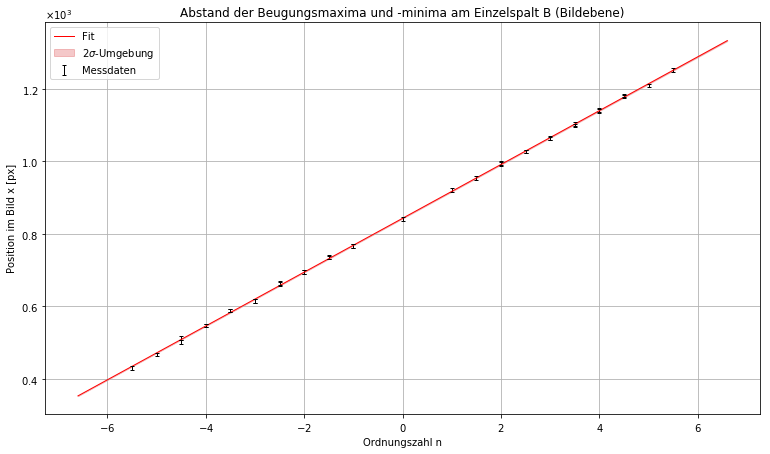

In [73]:
x_ord1 = np.array([512,547,588,615,662,694,735,767,841,921,954,993,1027,1063,1099,1141,1182])
Fehler_x_ord1 = np.full(x_ord1.size, 5)
n_ord1 = np.array([-4.5,-4,-3.5,-3,-2.5,-2,-1.5,-1,0,1,1.5,2,2.5,3,3.5,4,4.5])

x_ord2 = np.array([429,467,502,547,588,615,664,695,736,767,995,1027,1065,1103,1139,1179,1209,1252])
Fehler_x_ord2 = np.full(x_ord2.size, 5)
n_ord2 = np.array([-5.5,-5,-4.5,-4,-3.5,-3,-2.5,-2,-1.5,-1,2,2.5,3,3.5,4,4.5,5,5.5])

x = np.concatenate((n_ord1, n_ord2))
y = np.concatenate((x_ord1, x_ord2))
Fehler_y = np.concatenate((Fehler_x_ord1, Fehler_x_ord2))

#Fitfunktion
from scipy.optimize import curve_fit

def fit_func(x,s,c):
    return s*x+c

popt, pcov = curve_fit(fit_func, x, y)

#Sigma-Umgebung
nstd = 2 # um n-Sigma-Umgebung im Diagramm zu zeichnen
popt_top = popt+nstd*np.diag(pcov)
popt_bot = popt-nstd*np.diag(pcov)

#Plot-Umgebung
x_fit = np.linspace(min(x)-(max(x)-min(x))/10, max(x)+(max(x)-min(x))/10, 1000)
fit = fit_func(x_fit, *popt)
fit_top = fit_func(x_fit, *popt_top)
fit_bot = fit_func(x_fit, *popt_bot)

#Plot
fig, ax = plt.subplots(1, figsize=[6.4 *2, 4.8 *1.5])
plt.ticklabel_format(axis='both', style='sci', scilimits=(0,3), useMathText=True)
plt.plot(x_fit, fit, 'r', lw=1, label='Fit')
plt.errorbar(x, y, yerr=Fehler_y, lw=1, ecolor='k', fmt='none', capsize=2, label='Messdaten')
ax.fill_between(x_fit, fit_top, fit_bot, color='C3', alpha=.25, label=str(nstd)+r'$\sigma$'+'-Umgebung')
plt.title('Abstand der Beugungsmaxima und -minima am Einzelspalt B (Bildebene)')
plt.grid(True)
plt.xlabel('Ordnungszahl n')
plt.ylabel('Position im Bild x [px]')
plt.legend(loc='best')

fig.savefig('figures/233_Fig23.pdf', format='pdf', bbox_inches='tight')

#Chi-Quadrat orthogonal
dof = x.size-popt.size
chisquare = np.sum((fit_func(x,*popt)-y)**2/Fehler_y**2)
chisquare_red = chisquare/dof
prob = round(1-chi2.cdf(chisquare,dof),2)*100

#Auswertung
S_1 = popt[0]
Fehler_S_1 = pcov[0][0]

#Ausgabe
print('Abstand pro Ordnungszahl in der Bildebene:')
print('S_1 [px / 1] =', format_e(S_1), ' +- ', format_e(Fehler_S_1))
print('Chi-Quadrat =', chisquare)
print('Freiheitsgrade =', dof)
print('Chi-Quadrat reduziert =', chisquare_red)
print('Wahrscheinlichkeit ein größeres oder gleiches Chi-Quadrat zu erhalten =', prob, '%')

Abstand pro Ordnungszahl in der Fourierebene:
S_2 [mm / 1] = 2.1e-01  +-  9e-05
Nullabwert:
d_0 [mm] = 5.5e-02  +-  6.75e-04
Chi-Quadrat = 7.4380165289256235
Freiheitsgrade = 2
Chi-Quadrat reduziert = 3.7190082644628117
Wahrscheinlichkeit ein größeres oder gleiches Chi-Quadrat zu erhalten = 2.0 %


Abbildungsmaßstab:
beta [px / mm] = 3.537386e+02  +-  2.211107e-01
beta [1] = 4.952341e+00  +-  7.081542e-02


Beugungsspaltbreite:
D [mm] = 2.904305e-01  +-  3.725709e-03


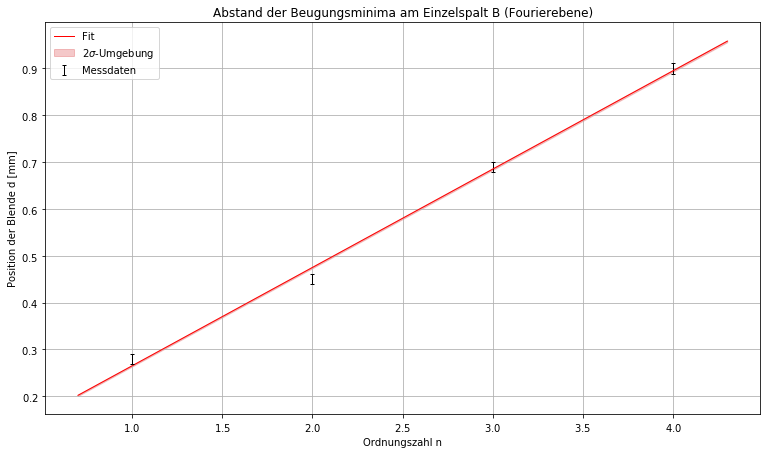

In [112]:
d_ord = np.array([0.19,0.36,0.60,0.81])+0.090
Fehler_d_ord = np.full(d_ord.size, 0.011)
n_ord = np.array([1,2,3,4])

x = n_ord
y = d_ord
Fehler_y = Fehler_d_ord

#Fitfunktion
from scipy.optimize import curve_fit

def fit_func(x,s,c):
    return s*x+c

popt, pcov = curve_fit(fit_func, x, y)

#Sigma-Umgebung
nstd = 2 # um n-Sigma-Umgebung im Diagramm zu zeichnen
popt_top = popt+nstd*np.diag(pcov)
popt_bot = popt-nstd*np.diag(pcov)

#Plot-Umgebung
x_fit = np.linspace(min(x)-(max(x)-min(x))/10, max(x)+(max(x)-min(x))/10, 1000)
fit = fit_func(x_fit, *popt)
fit_top = fit_func(x_fit, *popt_top)
fit_bot = fit_func(x_fit, *popt_bot)

#Plot
fig, ax = plt.subplots(1, figsize=[6.4 *2, 4.8 *1.5])
plt.ticklabel_format(axis='both', style='sci', scilimits=(0,3), useMathText=True)
plt.plot(x_fit, fit, 'r', lw=1, label='Fit')
plt.errorbar(x, y, yerr=Fehler_y, lw=1, ecolor='k', fmt='none', capsize=2, label='Messdaten')
ax.fill_between(x_fit, fit_top, fit_bot, color='C3', alpha=.25, label=str(nstd)+r'$\sigma$'+'-Umgebung')
plt.title('Abstand der Beugungsminima am Einzelspalt B (Fourierebene)')
plt.grid(True)
plt.xlabel('Ordnungszahl n')
plt.ylabel('Position der Blende d [mm]')
plt.legend(loc='best')

fig.savefig('figures/233_Fig24.pdf', format='pdf', bbox_inches='tight')

#Chi-Quadrat orthogonal
dof = x.size-popt.size
chisquare = np.sum((fit_func(x,*popt)-y)**2/Fehler_y**2)
chisquare_red = chisquare/dof
prob = round(1-chi2.cdf(chisquare,dof),2)*100

#Auswertung
S_2 = popt[0]
Fehler_S_2 = pcov[0][0]
d_0 = popt[1]
Fehler_d_0 = pcov[1][1]

lamda = 635 *1e-06
Fehler_lamda = 1 *1e-06
f = 80
Fehler_f = 1
b_px  = 0.0140
Fehler_b_px = 0.0002

beta_px = S_1/S_2
Fehler_beta_px = beta_px*np.sqrt((Fehler_S_1/S_1)**2+(Fehler_S_2/S_2)**2)

beta = beta_px*b_px
Fehler_beta = beta*np.sqrt((Fehler_beta_px/beta_px)**2+(Fehler_b_px/b_px)**2)

D = lamda*f*((a/b_px)+1/S_2)
Fehler_D = D*np.sqrt((Fehler_lamda/lamda)**2+(Fehler_f/f)**2
                     +(((a/b_px)**2)*((Fehler_a/a)**2+(Fehler_b_px/b_px)**2)+(1/S_2)**2*(Fehler_S_2/S_2)**2)
                     /(((a/b_px)+1/S_2)**2))

#Ausgabe
print('Abstand pro Ordnungszahl in der Fourierebene:')
print('S_2 [mm / 1] =', format_e(S_2), ' +- ', format_e(Fehler_S_2))
print('Nullabwert:')
print('d_0 [mm] =', format_e(d_0), ' +- ', format_e(Fehler_d_0))
print('Chi-Quadrat =', chisquare)
print('Freiheitsgrade =', dof)
print('Chi-Quadrat reduziert =', chisquare_red)
print('Wahrscheinlichkeit ein größeres oder gleiches Chi-Quadrat zu erhalten =', prob, '%')
print('\n')
print('Abbildungsmaßstab:')
print('beta [px / mm] =', format_e(beta_px), ' +- ', format_e(Fehler_beta_px))
print('beta [1] =', format_e(beta), ' +- ', format_e(Fehler_beta))
print('\n')
print('Beugungsspaltbreite:')
print('D [mm] =', format_e(D), ' +- ', format_e(Fehler_D))

Doppelspalt A: 
Abszissenskalierung: 
a = 6.146099e-03  +-  1.286931e-05
Hintergrundrauschen: 
h = 5.962934e+01  +-  9.645757e-02
Spaltverhältnis: 
v = 5.155925e+00  +-  1.098975e-02
Chi-Quadrat = 7642.954572100971
Freiheitsgrade = 2043
Chi-Quadrat reduziert = 3.7410448223695405
Wahrscheinlichkeit ein größeres oder gleiches Chi-Quadrat zu erhalten = 0.0 %


Beugungsspaltbreite:
D [mm] = 2.642063e-01  +-  3.34583e-03


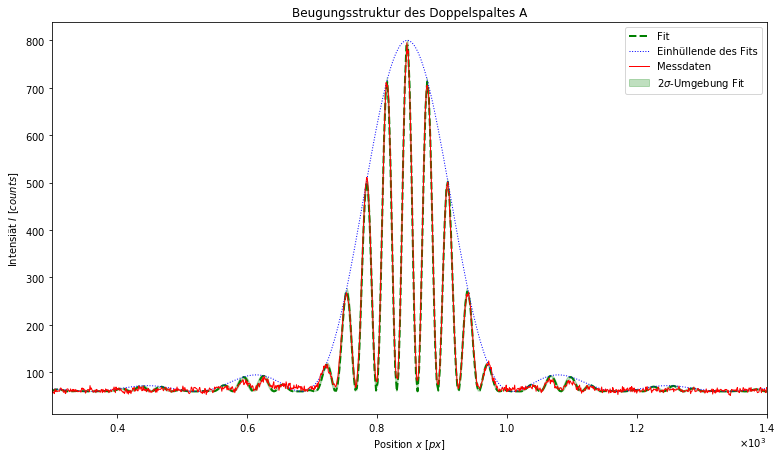

In [113]:
x, I = np.loadtxt('data/233.2.2.ccd',skiprows=14,usecols=(0, 1), unpack=True)

Fehler_x = np.full(len(x), 1)
Fehler_I = np.full(len(I), 2)

#Fitfunktion
from scipy import odr

def fit_func(p, x):
    (h, A, mu, a, v) = p # c: Konstante
    return A*beugung_doppelspalt(a*(x-mu), v)+h

model = odr.Model(fit_func)

#darzustellende Daten
x = x
y = I
delta_x = Fehler_x
delta_y = Fehler_I

#Startparameter
try:
    popt_iterateA
except NameError:
    para0 = [60, 750, 845, 0.006, 5.4]
else: 
    para0 = popt_iterateA

data = odr.RealData(x, y, sx=delta_x, sy=delta_y)
odr = odr.ODR(data, model, beta0=para0 )
out = odr.run()

#1-Sigma
popt = out.beta
perr = out.sd_beta

#Sigma-Umgebung
nstd = 2 # um n-Sigma-Umgebung im Diagramm zu zeichnen

popt_top = popt+nstd*perr
popt_bot = popt-nstd*perr

#Plot-Umgebung
x_fit = np.linspace(min(x)-(max(x)-min(x))/10, max(x)+(max(x)-min(x))/10, 1000)
fit = fit_func(popt, x_fit)
fit_top = fit_func(popt_top, x_fit)
fit_bot = fit_func(popt_bot, x_fit)
envelope = popt[1]*beugung_spalt(popt[3]*(x_fit-popt[2]))+popt[0]

chisquare = out.sum_square
dof=len(x)-popt.size #dof:degrees of freedom, Freiheitsgrad
chisquare_red = chisquare/dof
prob = round(1-chi2.cdf(chisquare,dof),2)*100

fig, ax = plt.subplots(1, figsize=[6.4 *2, 4.8 *1.5])
plt.ticklabel_format(axis='both', style='sci', scilimits=(0,3), useMathText=True)
plt.title('Beugungsstruktur des Doppelspaltes A')
plt.xlim(300, 1400)
plt.plot(x_fit, fit, 'g--', lw=2, label='Fit')
ax.fill_between(x_fit, fit_top, fit_bot, color='g', alpha=.25, label=str(nstd)+'$\sigma$-Umgebung Fit')
plt.plot(x_fit, envelope, 'b:', lw=1, label='Einhüllende des Fits')
plt.xlabel('Position '+r'${x}$'+' '+r'${[px]}$')
plt.ylabel('Intensiät '+r'${I}$'+' '+r'${[counts]}$')
plt.plot(x, I, 'r', lw=1, label='Messdaten')
plt.legend(loc='best')
plt.savefig('figures/233_Fig8prov.pdf', format='pdf', bbox_inches='tight')

#Auswertung
a = popt[3]
Fehler_a = perr[3]

h = popt[0]
Fehler_h = perr[0]

v = popt[4]
Fehler_v = perr[4]

D = lamda*f*((a/b_px)+1/S_2)
Fehler_D = D*np.sqrt((Fehler_lamda/lamda)**2+(Fehler_f/f)**2
                     +(((a/b_px)**2)*((Fehler_a/a)**2+(Fehler_b_px/b_px)**2)+(1/S_2)**2*(Fehler_S_2/S_2)**2)
                     /(((a/b_px)+1/S_2)**2))

#Ausgabe
print('Doppelspalt A: ')
print('Abszissenskalierung: ')
print('a =', format_e(a), ' +- ', format_e(Fehler_a))
print('Hintergrundrauschen: ')
print('h =', format_e(h), ' +- ', format_e(Fehler_h))
print('Spaltverhältnis: ')
print('v =', format_e(v), ' +- ', format_e(Fehler_v))
print('Chi-Quadrat =', chisquare)
print('Freiheitsgrade =', dof)
print('Chi-Quadrat reduziert =', chisquare_red)
print('Wahrscheinlichkeit ein größeres oder gleiches Chi-Quadrat zu erhalten =', prob, '%')
print('\n')
print('Beugungsspaltbreite:')
print('D [mm] =', format_e(D), ' +- ', format_e(Fehler_D))

popt_iterateA = popt

Doppelspalt B: 
Abzisenskalierung: 
a = 1.337943e-02  +-  1.47226e-05
Hintergrundrauschen: 
h = 5.937805e+01  +-  1.174223e-01
Spaltverhältnis: 
v = 2.40071e+00  +-  2.724881e-03
Chi-Quadrat = 10911.366241287624
Freiheitsgrade = 2043
Chi-Quadrat reduziert = 5.340854743655225
Wahrscheinlichkeit ein größeres oder gleiches Chi-Quadrat zu erhalten = 0.0 %


Beugungsspaltbreite:
D [mm] = 2.90453e-01  +-  3.72633e-03


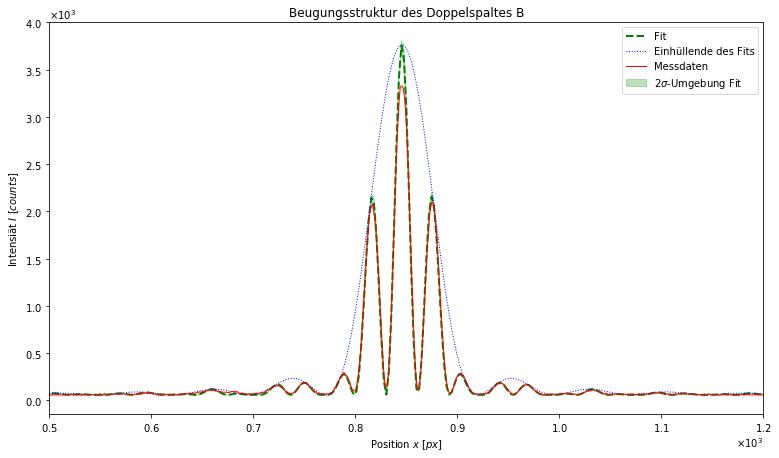

In [114]:
x, I = np.loadtxt('data/233.2.1.ccd',skiprows=14,usecols=(0, 1), unpack=True)

Fehler_x = np.full(len(x), 1)
Fehler_I = np.full(len(I), 2)
#Fitfunktion
from scipy import odr

def fit_func(p, x):
    (h, A, mu, a, v) = p # c: Konstante
    return A*beugung_doppelspalt(a*(x-mu), v)+h

model = odr.Model(fit_func)

#darzustellende Daten
x = x
y = I
delta_x = Fehler_x
delta_y = Fehler_I

#Startparameter
try:
    popt_iterateB
except NameError:
    para0 = [60, 3000, 845, 0.013, 2.5]
else: 
    para0 = popt_iterateB
    
data = odr.RealData(x, y, sx=delta_x, sy=delta_y)
odr = odr.ODR(data, model, beta0=para0 )
out = odr.run()

#1-Sigma
popt = out.beta
perr = out.sd_beta

#Sigma-Umgebung
nstd = 2 # um n-Sigma-Umgebung im Diagramm zu zeichnen

popt_top = popt+nstd*perr
popt_bot = popt-nstd*perr

#Plot-Umgebung
x_fit = np.linspace(min(x)-(max(x)-min(x))/10, max(x)+(max(x)-min(x))/10, 1000)
fit = fit_func(popt, x_fit)
fit_top = fit_func(popt_top, x_fit)
fit_bot = fit_func(popt_bot, x_fit)
envelope = popt[1]*beugung_spalt(popt[3]*(x_fit-popt[2]))+popt[0]

chisquare = out.sum_square
dof=len(x)-popt.size #dof:degrees of freedom, Freiheitsgrad
chisquare_red = chisquare/dof
prob = round(1-chi2.cdf(chisquare,dof),2)*100

fig, ax = plt.subplots(1, figsize=[6.4 *2, 4.8 *1.5])
plt.ticklabel_format(axis='both', style='sci', scilimits=(0,3), useMathText=True)
plt.title('Beugungsstruktur des Doppelspaltes B')
plt.xlim(500, 1200)
plt.plot(x_fit, fit, 'g--', lw=2, label='Fit')
ax.fill_between(x_fit, fit_top, fit_bot, color='g', alpha=.25, label=str(nstd)+'$\sigma$-Umgebung Fit')
plt.plot(x_fit, envelope, 'b:', lw=1, label='Einhüllende des Fits')
plt.xlabel('Position '+r'${x}$'+' '+r'${[px]}$')
plt.ylabel('Intensiät '+r'${I}$'+' '+r'${[counts]}$')
plt.plot(x, I, 'r', lw=1, label='Messdaten')
plt.legend(loc='best')
plt.savefig('figures/233_Fig7prov.pdf', format='pdf', bbox_inches='tight')

#Auswertung
a = popt[3]
Fehler_a = perr[3]

h = popt[0]
Fehler_h = perr[0]

v = popt[4]
Fehler_v = perr[4]

D = lamda*f*((a/b_px)+1/S_2)
Fehler_D = D*np.sqrt((Fehler_lamda/lamda)**2+(Fehler_f/f)**2
                     +(((a/b_px)**2)*((Fehler_a/a)**2+(Fehler_b_px/b_px)**2)+(1/S_2)**2*(Fehler_S_2/S_2)**2)
                     /(((a/b_px)+1/S_2)**2))

#Ausgabe
print('Doppelspalt B: ')
print('Abzisenskalierung: ')
print('a =', format_e(a), ' +- ', format_e(Fehler_a))
print('Hintergrundrauschen: ')
print('h =', format_e(h), ' +- ', format_e(Fehler_h))
print('Spaltverhältnis: ')
print('v =', format_e(v), ' +- ', format_e(Fehler_v))
print('Chi-Quadrat =', chisquare)
print('Freiheitsgrade =', dof)
print('Chi-Quadrat reduziert =', chisquare_red)
print('Wahrscheinlichkeit ein größeres oder gleiches Chi-Quadrat zu erhalten =', prob, '%')
print('\n')
print('Beugungsspaltbreite:')
print('D [mm] =', format_e(D), ' +- ', format_e(Fehler_D))

popt_iterateB = popt

Doppelspalt C: 
Abszissenskalierung: 
a = 1.416199e-02  +-  1.228906e-05
Hintergrundrauschen: 
h = 6.001406e+01  +-  9.863223e-02
Spaltverhältnis: 
v = 4.562983e+00  +-  3.980214e-03
Chi-Quadrat = 6670.375963166861
Freiheitsgrade = 2043
Chi-Quadrat reduziert = 3.264990681922105
Wahrscheinlichkeit ein größeres oder gleiches Chi-Quadrat zu erhalten = 0.0 %


Beugungsspaltbreite:
D [mm] = 2.932925e-01  +-  3.769044e-03


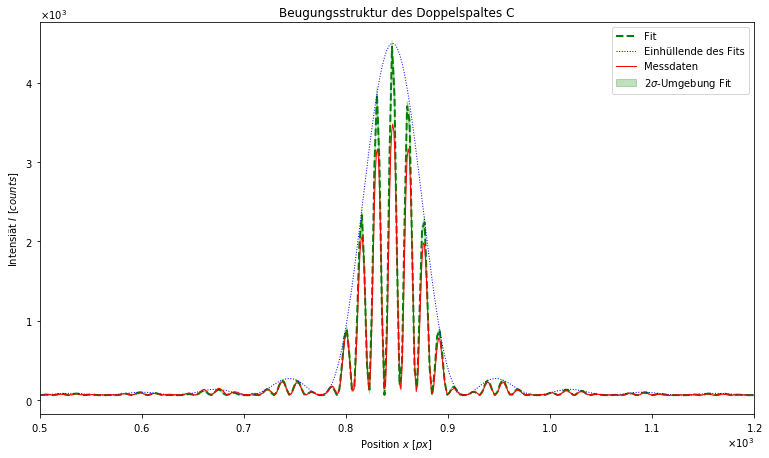

In [108]:
x, I = np.loadtxt('data/233.2.3.ccd',skiprows=14,usecols=(0, 1), unpack=True)

Fehler_x = np.full(len(x), 1)
Fehler_I = np.full(len(I), 2)
#Fitfunktion
from scipy import odr

def fit_func(p, x):
    (h, A, mu, a, v) = p # c: Konstante
    return A*beugung_doppelspalt(a*(x-mu), v)+h

model = odr.Model(fit_func)

#darzustellende Daten
x = x
y = I
delta_x = Fehler_x
delta_y = Fehler_I

#Startparameter
try:
    popt_iterateC
except NameError:
    para0 = [60, 3500, 845, 0.013, 5]
else: 
    para0 = popt_iterateC
    
data = odr.RealData(x, y, sx=delta_x, sy=delta_y)
odr = odr.ODR(data, model, beta0=para0 )
out = odr.run()

#1-Sigma
popt = out.beta
perr = out.sd_beta

#Sigma-Umgebung
nstd = 2 # um n-Sigma-Umgebung im Diagramm zu zeichnen

popt_top = popt+nstd*perr
popt_bot = popt-nstd*perr

#Plot-Umgebung
x_fit = np.linspace(min(x)-(max(x)-min(x))/10, max(x)+(max(x)-min(x))/10, 1000)
fit = fit_func(popt, x_fit)
fit_top = fit_func(popt_top, x_fit)
fit_bot = fit_func(popt_bot, x_fit)
envelope = popt[1]*beugung_spalt(popt[3]*(x_fit-popt[2]))+popt[0]

chisquare = out.sum_square
dof=len(x)-popt.size #dof:degrees of freedom, Freiheitsgrad
chisquare_red = chisquare/dof
prob = round(1-chi2.cdf(chisquare,dof),2)*100

fig, ax = plt.subplots(1, figsize=[6.4 *2, 4.8 *1.5])
plt.ticklabel_format(axis='both', style='sci', scilimits=(0,3), useMathText=True)
plt.title('Beugungsstruktur des Doppelspaltes C')
plt.xlim(500, 1200)
plt.plot(x_fit, fit, 'g--', lw=2, label='Fit')
ax.fill_between(x_fit, fit_top, fit_bot, color='g', alpha=.25, label=str(nstd)+'$\sigma$-Umgebung Fit')
plt.plot(x_fit, envelope, 'b:', lw=1, label='Einhüllende des Fits')
plt.xlabel('Position '+r'${x}$'+' '+r'${[px]}$')
plt.ylabel('Intensiät '+r'${I}$'+' '+r'${[counts]}$')
plt.plot(x, I, 'r', lw=1, label='Messdaten')
plt.legend(loc='best')
plt.savefig('figures/233_Fig9prov.pdf', format='pdf', bbox_inches='tight')

#Auswertung
a = popt[3]
Fehler_a = perr[3]

h = popt[0]
Fehler_h = perr[0]

v = popt[4]
Fehler_v = perr[4]

D = lamda*f*((a/b_px)+1/S_2)
Fehler_D = D*np.sqrt((Fehler_lamda/lamda)**2+(Fehler_f/f)**2
                     +(((a/b_px)**2)*((Fehler_a/a)**2+(Fehler_b_px/b_px)**2)+(1/S_2)**2*(Fehler_S_2/S_2)**2)
                     /(((a/b_px)+1/S_2)**2))

#Ausgabe
print('Doppelspalt C: ')
print('Abszissenskalierung: ')
print('a =', format_e(a), ' +- ', format_e(Fehler_a))
print('Hintergrundrauschen: ')
print('h =', format_e(h), ' +- ', format_e(Fehler_h))
print('Spaltverhältnis: ')
print('v =', format_e(v), ' +- ', format_e(Fehler_v))
print('Chi-Quadrat =', chisquare)
print('Freiheitsgrade =', dof)
print('Chi-Quadrat reduziert =', chisquare_red)
print('Wahrscheinlichkeit ein größeres oder gleiches Chi-Quadrat zu erhalten =', prob, '%')
print('\n')
print('Beugungsspaltbreite:')
print('D [mm] =', format_e(D), ' +- ', format_e(Fehler_D))

popt_iterateC = popt

C:\ProgramData\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:385: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


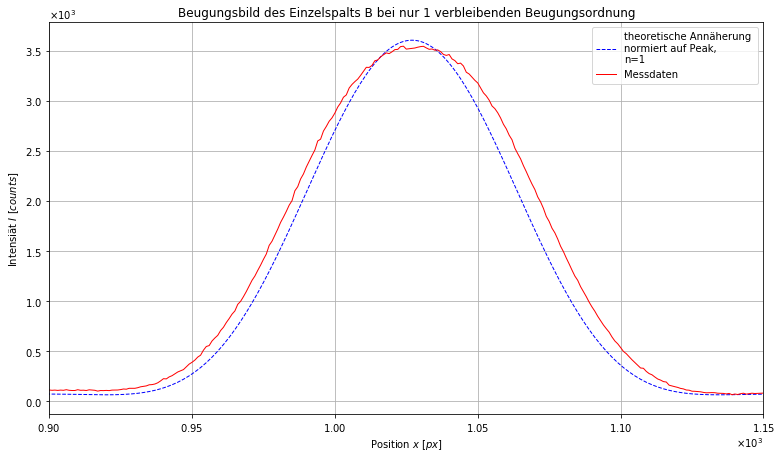

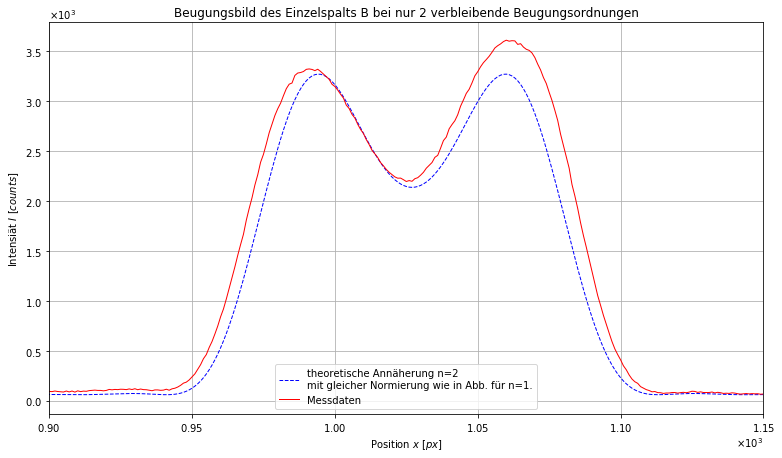

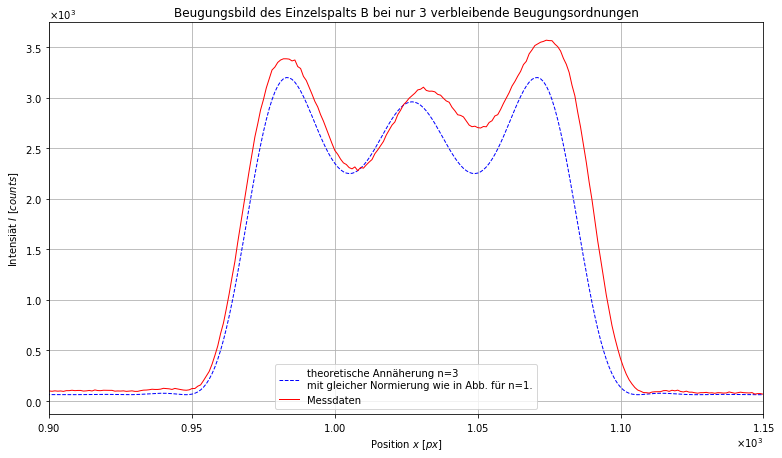

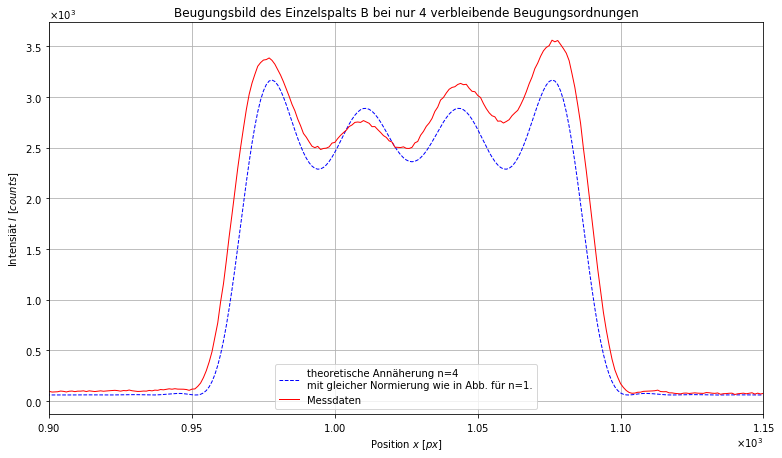

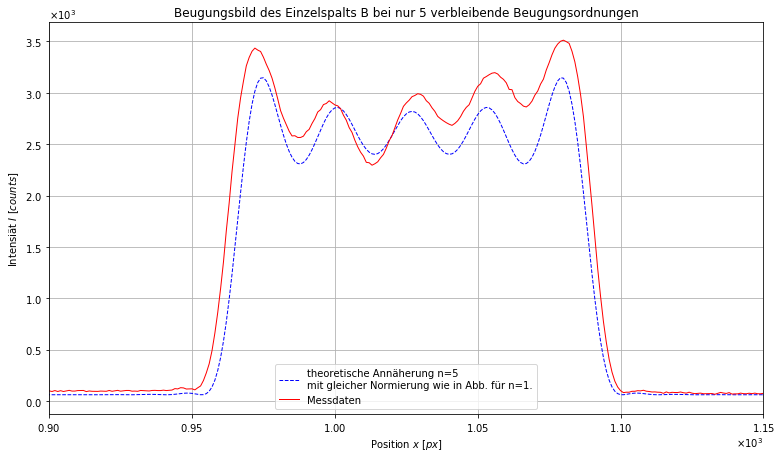

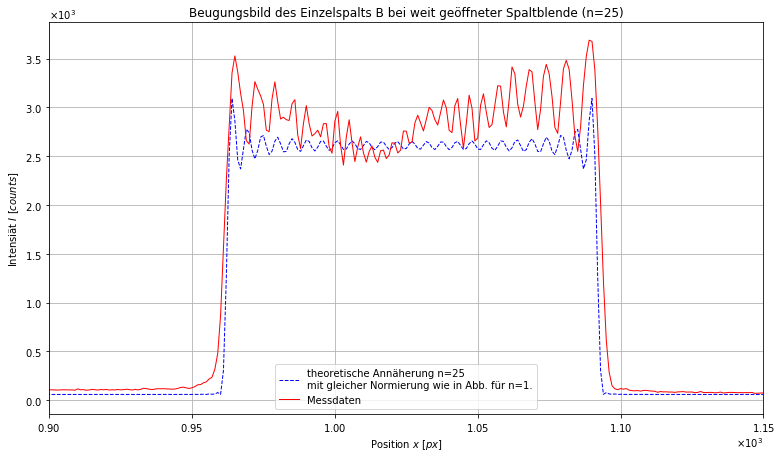

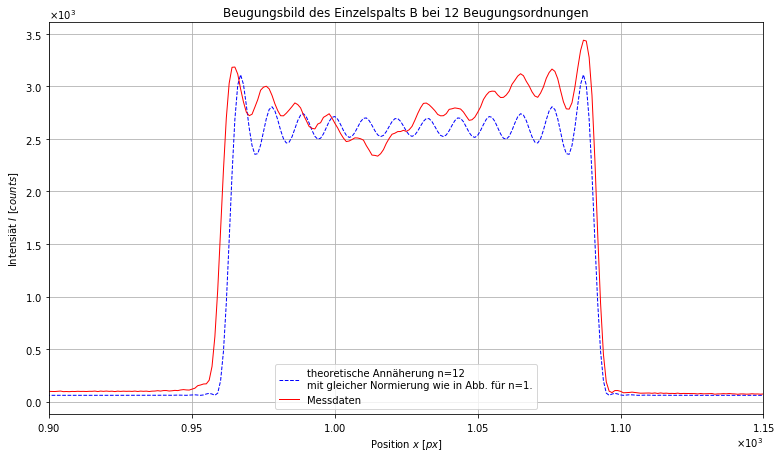

In [101]:
mu = 1027
h = 60
d=131

x, I = np.loadtxt('data/233.3.1.ccd',skiprows=14,usecols=(0, 1), unpack=True)
n=1 #Integrationsbereich

f_modifiziert=[]
for i in range(len(x)):
    y=x[i]-mu
    result, error = quad(spalt, 0, 2*np.pi*n/d)
    f_modifiziert.append(result**2)
A = np.max(I)/np.max(f_modifiziert)
f_modifiziert=A*np.array(f_modifiziert)+h
fig, ax = plt.subplots(1, figsize=[6.4 *2, 4.8 *1.5])
plt.ticklabel_format(axis='both', style='sci', scilimits=(0,3), useMathText=True)
plt.title('Beugungsbild des Einzelspalts B bei nur 1 verbleibenden Beugungsordnung')
plt.grid(True)
plt.plot(x,f_modifiziert, 'b--', lw=1, label='theoretische Annäherung \nnormiert auf Peak, \nn=1')
plt.xlim(900, 1150)
plt.xlabel('Position '+r'${x}$'+' '+r'${[px]}$')
plt.ylabel('Intensiät '+r'${I}$'+' '+r'${[counts]}$')
plt.plot(x, I, 'r', lw=1, label='Messdaten')
plt.legend(loc='best')
plt.savefig('figures/233_Fig10.pdf', format='pdf', bbox_inches='tight')

x, I = np.loadtxt('data/233.3.2.ccd',skiprows=14,usecols=(0, 1), unpack=True)
n=2 #Integrationsbereich
f_modifiziert=[]
for i in range(len(x)):
    y=x[i]-mu
    result, error = quad(spalt, 0, 2*np.pi*n/d)
    f_modifiziert.append(result**2)
f_modifiziert=A*np.array(f_modifiziert)+h
fig, ax = plt.subplots(1, figsize=[6.4 *2, 4.8 *1.5])
plt.ticklabel_format(axis='both', style='sci', scilimits=(0,3), useMathText=True)
plt.title('Beugungsbild des Einzelspalts B bei nur 2 verbleibende Beugungsordnungen')
plt.grid(True)
plt.plot(x,f_modifiziert, 'b--', lw=1, label='theoretische Annäherung n=2\nmit gleicher Normierung wie in Abb. für n=1.')
plt.xlim(900, 1150)
plt.xlabel('Position '+r'${x}$'+' '+r'${[px]}$')
plt.ylabel('Intensiät '+r'${I}$'+' '+r'${[counts]}$')
plt.plot(x, I, 'r', lw=1, label='Messdaten')
plt.legend(loc='best')
plt.savefig('figures/233_Fig11.pdf', format='pdf', bbox_inches='tight')

x, I = np.loadtxt('data/233.3.3.ccd',skiprows=14,usecols=(0, 1), unpack=True)
n=3 #Integrationsbereich
f_modifiziert=[]
for i in range(len(x)):
    y=x[i]-mu
    result, error = quad(spalt, 0, 2*np.pi*n/d)
    f_modifiziert.append(result**2)
f_modifiziert=A*np.array(f_modifiziert)+h
fig, ax = plt.subplots(1, figsize=[6.4 *2, 4.8 *1.5])
plt.ticklabel_format(axis='both', style='sci', scilimits=(0,3), useMathText=True)
plt.title('Beugungsbild des Einzelspalts B bei nur 3 verbleibende Beugungsordnungen')
plt.grid(True)
plt.plot(x,f_modifiziert, 'b--', lw=1, label='theoretische Annäherung n=3\nmit gleicher Normierung wie in Abb. für n=1.')
plt.xlim(900, 1150)
plt.xlabel('Position '+r'${x}$'+' '+r'${[px]}$')
plt.ylabel('Intensiät '+r'${I}$'+' '+r'${[counts]}$')
plt.plot(x, I, 'r', lw=1, label='Messdaten')
plt.legend(loc='best')
plt.savefig('figures/233_Fig12.pdf', format='pdf', bbox_inches='tight')

x, I = np.loadtxt('data/233.3.4.ccd',skiprows=14,usecols=(0, 1), unpack=True)
n=4 #Integrationsbereich
f_modifiziert=[]
for i in range(len(x)):
    y=x[i]-mu
    result, error = quad(spalt, 0, 2*np.pi*n/d)
    f_modifiziert.append(result**2)
f_modifiziert=A*np.array(f_modifiziert)+h
fig, ax = plt.subplots(1, figsize=[6.4 *2, 4.8 *1.5])
plt.ticklabel_format(axis='both', style='sci', scilimits=(0,3), useMathText=True)
plt.title('Beugungsbild des Einzelspalts B bei nur 4 verbleibende Beugungsordnungen')
plt.grid(True)
plt.plot(x,f_modifiziert, 'b--', lw=1, label='theoretische Annäherung n=4\nmit gleicher Normierung wie in Abb. für n=1.')
plt.xlim(900, 1150)
plt.xlabel('Position '+r'${x}$'+' '+r'${[px]}$')
plt.ylabel('Intensiät '+r'${I}$'+' '+r'${[counts]}$')
plt.plot(x, I, 'r', lw=1, label='Messdaten')
plt.legend(loc='best')
plt.savefig('figures/233_Fig13.pdf', format='pdf', bbox_inches='tight')

x, I = np.loadtxt('data/233.3.5.ccd',skiprows=14,usecols=(0, 1), unpack=True)
n=5 #Integrationsbereich
f_modifiziert=[]
for i in range(len(x)):
    y=x[i]-mu
    result, error = quad(spalt, 0, 2*np.pi*n/d)
    f_modifiziert.append(result**2)
f_modifiziert=A*np.array(f_modifiziert)+h
fig, ax = plt.subplots(1, figsize=[6.4 *2, 4.8 *1.5])
plt.ticklabel_format(axis='both', style='sci', scilimits=(0,3), useMathText=True)
plt.title('Beugungsbild des Einzelspalts B bei nur 5 verbleibende Beugungsordnungen')
plt.grid(True)
plt.plot(x,f_modifiziert, 'b--', lw=1, label='theoretische Annäherung n=5\nmit gleicher Normierung wie in Abb. für n=1.')
plt.xlim(900, 1150)
plt.xlabel('Position '+r'${x}$'+' '+r'${[px]}$')
plt.ylabel('Intensiät '+r'${I}$'+' '+r'${[counts]}$')
plt.plot(x, I, 'r', lw=1, label='Messdaten')
plt.legend(loc='best')
plt.savefig('figures/233_Fig14.pdf', format='pdf', bbox_inches='tight')

x, I = np.loadtxt('data/233.3.6 (alles offen).ccd',skiprows=14,usecols=(0, 1), unpack=True)
n=25 #Integrationsbereich
f_modifiziert=[]
for i in range(len(x)):
    y=x[i]-mu
    result, error = quad(spalt, 0, 2*np.pi*n/d)
    f_modifiziert.append(result**2)
f_modifiziert=A*np.array(f_modifiziert)+h
fig, ax = plt.subplots(1, figsize=[6.4 *2, 4.8 *1.5])
plt.ticklabel_format(axis='both', style='sci', scilimits=(0,3), useMathText=True)
plt.title('Beugungsbild des Einzelspalts B bei weit geöffneter Spaltblende (n=25)')
plt.grid(True)
plt.plot(x,f_modifiziert, 'b--', lw=1, label='theoretische Annäherung n=25\nmit gleicher Normierung wie in Abb. für n=1.')
plt.xlim(900, 1150)
plt.xlabel('Position '+r'${x}$'+' '+r'${[px]}$')
plt.ylabel('Intensiät '+r'${I}$'+' '+r'${[counts]}$')
plt.plot(x, I, 'r', lw=1, label='Messdaten')
plt.legend(loc='best')
plt.savefig('figures/233_Fig15.pdf', format='pdf', bbox_inches='tight')

x, I = np.loadtxt('data/233.3.7.ccd',skiprows=14,usecols=(0, 1), unpack=True)
n=12 #Integrationsbereich
f_modifiziert=[]
for i in range(len(x)):
    y=x[i]-mu
    result, error = quad(spalt, 0, 2*np.pi*n/d)
    f_modifiziert.append(result**2)
f_modifiziert=A*np.array(f_modifiziert)+h
fig, ax = plt.subplots(1, figsize=[6.4 *2, 4.8 *1.5])
plt.ticklabel_format(axis='both', style='sci', scilimits=(0,3), useMathText=True)
plt.title('Beugungsbild des Einzelspalts B bei 12 Beugungsordnungen')
plt.grid(True)
plt.plot(x,f_modifiziert, 'b--', lw=1, label='theoretische Annäherung n=12\nmit gleicher Normierung wie in Abb. für n=1.')
plt.xlim(900, 1150)
plt.xlabel('Position '+r'${x}$'+' '+r'${[px]}$')
plt.ylabel('Intensiät '+r'${I}$'+' '+r'${[counts]}$')
plt.plot(x, I, 'r', lw=1, label='Messdaten')
plt.legend(loc='best')
plt.savefig('figures/233_Fig16.pdf', format='pdf', bbox_inches='tight')

0.21498371335504887
kritische Ordnungszahl: 
n = 2.149837e-01  +-  3.545662e-03


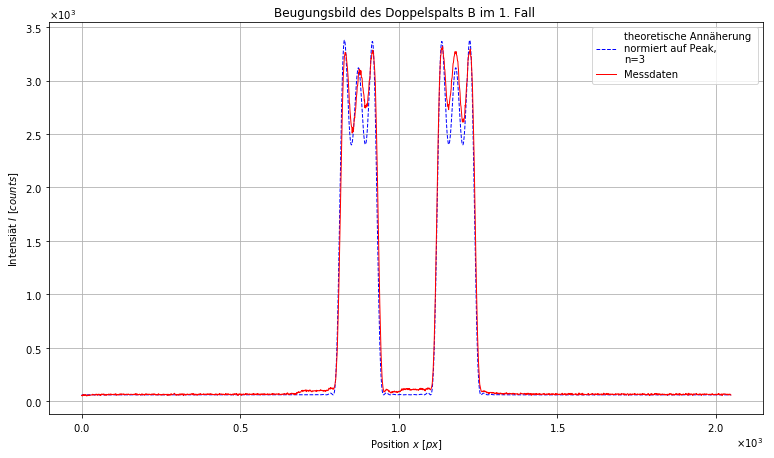

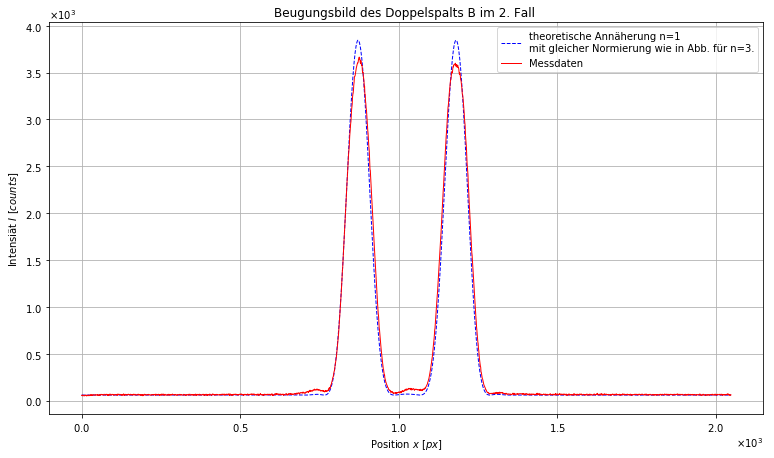

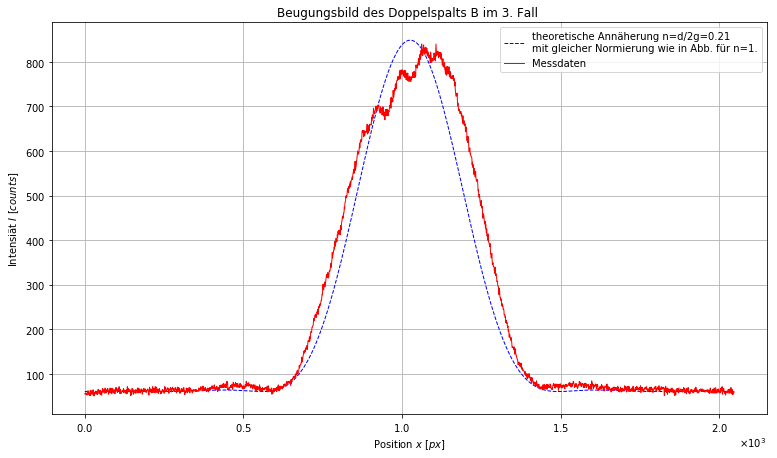

In [65]:
mu = 1026
h = 60
d=132
Fehler_d = 2
g = 307
Fehler_g = 2

n=3 #Integrationsbereich
x, I = np.loadtxt('data/233.4.1.ccd',skiprows=14,usecols=(0, 1), unpack=True)
f_modifiziert=[]
for i in range(len(x)):
    y=x[i]-mu
    result, error = quad(doppelspalt, 0, 2*np.pi*n/d)
    f_modifiziert.append(result**2)
A=np.max(I)/np.max(f_modifiziert)
f_modifiziert=A*np.array(f_modifiziert)+h
fig, ax = plt.subplots(1, figsize=[6.4 *2, 4.8 *1.5])
plt.ticklabel_format(axis='both', style='sci', scilimits=(0,3), useMathText=True)
plt.title('Beugungsbild des Doppelspalts B im 1. Fall ')
plt.grid(True)
plt.plot(x,f_modifiziert, 'b--', lw=1, label='theoretische Annäherung \nnormiert auf Peak, \nn=3')
plt.xlabel('Position '+r'${x}$'+' '+r'${[px]}$')
plt.ylabel('Intensiät '+r'${I}$'+' '+r'${[counts]}$')
plt.plot(x, I, 'r', lw=1, label='Messdaten')
plt.legend(loc='best')
plt.savefig('figures/233_Fig17.pdf', format='pdf', bbox_inches='tight')

n=1 #Integrationsbereich
x, I = np.loadtxt('data/233.4.2.ccd',skiprows=14,usecols=(0, 1), unpack=True)
f_modifiziert=[]
for i in range(len(x)):
    y=x[i]-mu
    result, error = quad(doppelspalt, 0, 2*np.pi*n/d)
    f_modifiziert.append(result**2)
f_modifiziert=A*np.array(f_modifiziert)+h
fig, ax = plt.subplots(1, figsize=[6.4 *2, 4.8 *1.5])
plt.ticklabel_format(axis='both', style='sci', scilimits=(0,3), useMathText=True)
plt.title('Beugungsbild des Doppelspalts B im 2. Fall ')
plt.grid(True)
plt.plot(x,f_modifiziert, 'b--', lw=1, label='theoretische Annäherung n=1\nmit gleicher Normierung wie in Abb. für n=3.')
plt.xlabel('Position '+r'${x}$'+' '+r'${[px]}$')
plt.ylabel('Intensiät '+r'${I}$'+' '+r'${[counts]}$')
plt.plot(x, I, 'r', lw=1, label='Messdaten')
plt.legend(loc='best')
plt.savefig('figures/233_Fig18.pdf', format='pdf', bbox_inches='tight')

n=d/g/2 #Integrationsbereich
Fehler_n = n*np.sqrt((Fehler_d/d)**2+(Fehler_g/g)**2)
print('kritische Ordnungszahl: ')
print('n =', format_e(n), ' +- ', format_e(Fehler_n))
x, I = np.loadtxt('data/233.4.3.ccd',skiprows=14,usecols=(0, 1), unpack=True)
f_modifiziert=[]
for i in range(len(x)):
    y=x[i]-mu
    result, error = quad(doppelspalt, 0, 2*np.pi*n/d)
    f_modifiziert.append(result**2)
f_modifiziert=A*np.array(f_modifiziert)+h
fig, ax = plt.subplots(1, figsize=[6.4 *2, 4.8 *1.5])
plt.ticklabel_format(axis='both', style='sci', scilimits=(0,3), useMathText=True)
plt.title('Beugungsbild des Doppelspalts B im 3. Fall ')
plt.grid(True)
plt.plot(x,f_modifiziert, 'b--', lw=1, label='theoretische Annäherung n=d/2g='+str(round(n,2))+'\nmit gleicher Normierung wie in Abb. für n=1.')
plt.xlabel('Position '+r'${x}$'+' '+r'${[px]}$')
plt.ylabel('Intensiät '+r'${I}$'+' '+r'${[counts]}$')
plt.plot(x, I, 'r', lw=1, label='Messdaten')
plt.legend(loc='best')
plt.savefig('figures/233_Fig19.pdf', format='pdf', bbox_inches='tight')

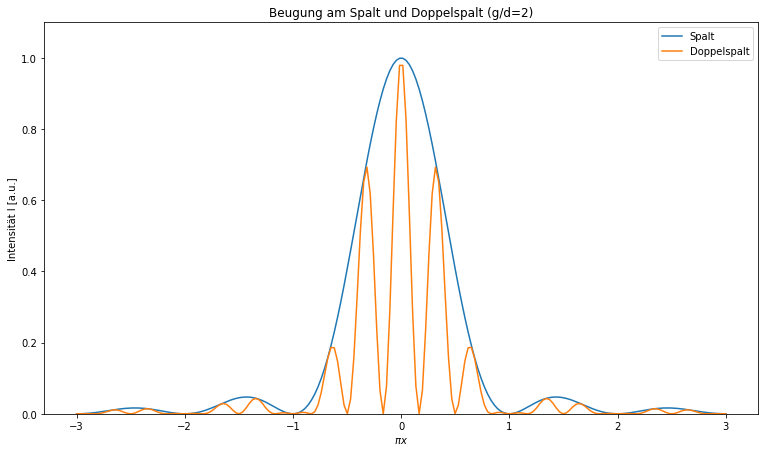

In [67]:
a=2
v=3
x=np.linspace(-(a+1),a+1,200)
fig, ax = plt.subplots(1, figsize=[6.4 *2, 4.8 *1.5])
plt.plot(x,beugung_spalt(x),label='Spalt')
plt.plot(x,beugung_doppelspalt(x, v),label='Doppelspalt')
plt.xlabel('$\pi x$')
plt.ylabel('Intensität I [a.u.]')
plt.title('Beugung am Spalt und Doppelspalt (g/d=2)')
plt.ylim((0,1.1))
plt.legend(loc='best')
plt.savefig("figures/233_Fig20.pdf", format="pdf")

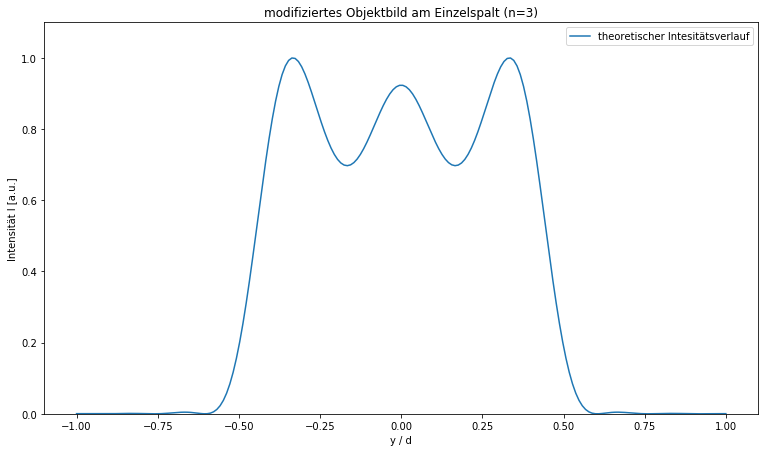

In [127]:
d=1 #Spaltbreite auf 1 setzen
n=3 #Integrationsbereich
Y=np.linspace(-1,1,200)*d

f_modifiziert=[]
for i in range(len(Y)):
    y=Y[i]
    result, error = quad(spalt, 0, 2*np.pi*n/d)
    f_modifiziert.append(result**2)

f_modifiziert=f_modifiziert/np.max(f_modifiziert)

fig, ax = plt.subplots(1, figsize=[6.4 *2, 4.8 *1.5])
plt.plot(Y,f_modifiziert, label='theoretischer Intesitätsverlauf')
plt.xlabel('y / d')
plt.ylabel('Intensität I [a.u.]')
plt.title('modifiziertes Objektbild am Einzelspalt (n=3)')
plt.ylim((0,1.1))
plt.legend(loc='best')
plt.savefig("figures/233_Fig21.pdf", format="pdf")

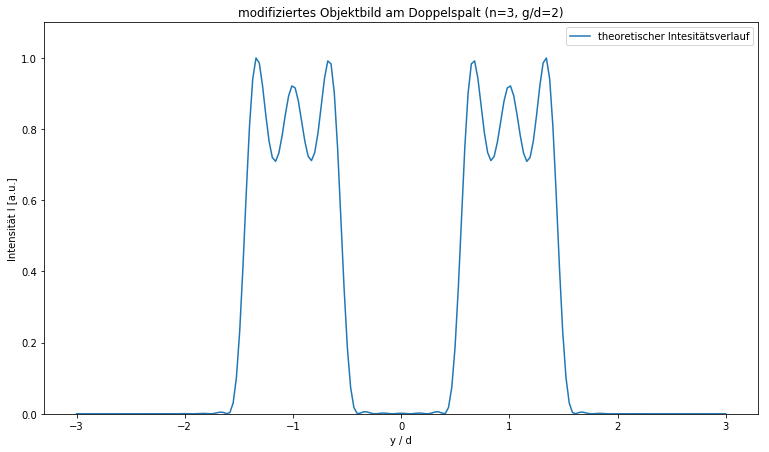

In [125]:
d=1 #Spaltbreite auf 1 setzen
n=3 #Integrationsbereich
g=2*d
Y=np.linspace(-1,1,200)*3*d

f_modifiziert=[]
for i in range(len(Y)):
    y=Y[i]
    result, error = quad(doppelspalt, 0, 2*np.pi*n/d)
    f_modifiziert.append(result**2)

f_modifiziert=f_modifiziert/np.max(f_modifiziert)

fig, ax = plt.subplots(1, figsize=[6.4 *2, 4.8 *1.5])
plt.plot(Y,f_modifiziert, label='theoretischer Intesitätsverlauf')
plt.xlabel('y / d')
plt.ylabel('Intensität I [a.u.]')
plt.title('modifiziertes Objektbild am Doppelspalt (n=3, g/d=2)')
plt.ylim((0,1.1))
plt.legend()
plt.savefig("figures/233_Fig22.pdf", format="pdf")

Abstand pro Ordnungszahl in der Bildebene:
S_3 [px / 1] = 1.118577e+01  +-  1.80183e-03
Chi-Quadrat = 2.393280632411085
Freiheitsgrade = 21
Chi-Quadrat reduziert = 0.11396574440052787
Wahrscheinlichkeit ein größeres oder gleiches Chi-Quadrat zu erhalten = 100.0 %


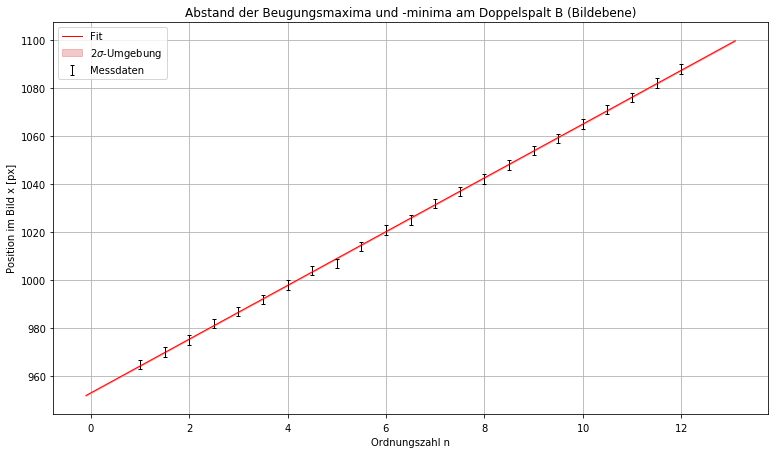

In [61]:
x_ord = np.array([965,970,975,982,987,992,998,1004,1007,1014,1021,1025,1032,1037,1042,1048,1054,1059,1065,1071,1076,1082,1088])
Fehler_x_ord = np.full(x_ord.size, 2)
n_ord = np.array([1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10,10.5,11,11.5,12])

x = n_ord
y = x_ord
Fehler_y = Fehler_x_ord

#Fitfunktion
from scipy.optimize import curve_fit

def fit_func(x,s,c):
    return s*x+c

popt, pcov = curve_fit(fit_func, x, y)

#Sigma-Umgebung
nstd = 2 # um n-Sigma-Umgebung im Diagramm zu zeichnen
popt_top = popt+nstd*np.diag(pcov)
popt_bot = popt-nstd*np.diag(pcov)

#Plot-Umgebung
x_fit = np.linspace(min(x)-(max(x)-min(x))/10, max(x)+(max(x)-min(x))/10, 1000)
fit = fit_func(x_fit, *popt)
fit_top = fit_func(x_fit, *popt_top)
fit_bot = fit_func(x_fit, *popt_bot)

#Plot
fig, ax = plt.subplots(1, figsize=[6.4 *2, 4.8 *1.5])
plt.ticklabel_format(axis='x', style='sci', scilimits=(0,3), useMathText=True)
plt.plot(x_fit, fit, 'r', lw=1, label='Fit')
plt.errorbar(x, y, yerr=Fehler_y, lw=1, ecolor='k', fmt='none', capsize=2, label='Messdaten')
ax.fill_between(x_fit, fit_top, fit_bot, color='C3', alpha=.25, label=str(nstd)+r'$\sigma$'+'-Umgebung')
plt.title('Abstand der Beugungsmaxima und -minima am Doppelspalt B (Bildebene)')
plt.grid(True)
plt.xlabel('Ordnungszahl n')
plt.ylabel('Position im Bild x [px]')
plt.legend(loc='best')

fig.savefig('figures/233_Fig25.pdf', format='pdf', bbox_inches='tight')

#Chi-Quadrat orthogonal
dof = x.size-popt.size
chisquare = np.sum((fit_func(x,*popt)-y)**2/Fehler_y**2)
chisquare_red = chisquare/dof
prob = round(1-chi2.cdf(chisquare,dof),2)*100

#Auswertung
s = popt[0]
s_std = pcov[0][0]

#Ausgabe
print('Abstand pro Ordnungszahl in der Bildebene:')
print('S_3 [px / 1] =', format_e(s), ' +- ', format_e(s_std))
print('Chi-Quadrat =', chisquare)
print('Freiheitsgrade =', dof)
print('Chi-Quadrat reduziert =', chisquare_red)
print('Wahrscheinlichkeit ein größeres oder gleiches Chi-Quadrat zu erhalten =', prob, '%')